In [ ]:
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset, Dataset


In [ ]:
from collections import Counter
from tqdm import tqdm

input_prompt = "What question was asked by the user if this were the sources used "

def get_dataset(use_extract=False, min_question_len=5, verbose=True, drop_duplicates=True):
    ds = load_dataset("openai/webgpt_comparisons", revision="refs/convert/parquet")
    train = ds["train"]

    reason_counter = Counter()

    def validate_row(row):
        q = row["question"]["full_text"].strip()
        titles0 = row["quotes_0"].get("title", [])
        titles1 = row["quotes_1"].get("title", [])
        extracts0 = row["quotes_0"].get("extract", [])
        extracts1 = row["quotes_1"].get("extract", [])

        if not q:
            reason_counter["empty_question"] += 1; return False
        if len(q) < min_question_len:
            reason_counter["short_question"] += 1; return False
        if not any(titles0 + titles1):
            reason_counter["no_titles"] += 1; return False
        if use_extract and not any(extracts0 + extracts1):
            reason_counter["no_extracts"] += 1; return False
        return True

    def build_input(titles, extracts):
        assert titles or extracts, "At least one of titles or extracts must be provided."
        parts = []
        # if both titles and extracts are used, put one by the other with zip()
        if use_extract and titles:
            parts.extend(f"<t>{t.strip()}</t> <c>{e.strip()}</c>" for t, e in zip(titles, extracts) if t.strip() and e.strip())
        if titles:
            parts.append("<t>" + " ; ".join(t.strip() for t in titles if t.strip()) + "</t>")
        if use_extract:
            clean_extracts = [e.strip() for e in extracts if e.strip()]
            if clean_extracts:
                parts.append("<c>" + " ; ".join(clean_extracts) + "</c>")
        return input_prompt + " ".join(parts)

    def transform_row(row):
        question = row["question"]["full_text"].strip()
        samples = []
        for qset in [row["quotes_0"], row["quotes_1"]]:
            titles = qset.get("title", [])
            extracts = qset.get("extract", [])
            if not any(t.strip() for t in titles):
                continue
            inp = build_input(titles, extracts)
            samples.append({"input": inp, "output": question})
        # per-row dedupe (in case quotes_0 and quotes_1 produce identical sample)
        uniq, seen = [], set()
        for s in samples:
            k = (s["input"], s["output"])
            if k in seen: continue
            seen.add(k); uniq.append(s)
        return uniq

    # build
    transformed_data = []
    total = 0
    for row in tqdm(train):
        total += 1
        if validate_row(row):
            transformed_data.extend(transform_row(row))

    # global dedupe
    if drop_duplicates:
        def norm(s): return " ".join(s.split())
        seen, deduped = set(), []
        for ex in transformed_data:
            key = (norm(ex["input"]), norm(ex["output"]))
            if key in seen: continue
            seen.add(key)
            deduped.append({"input": key[0], "output": key[1]})
        if verbose:
            print(f"\nDeduped {len(transformed_data) - len(deduped)} duplicates (kept {len(deduped)}).")
        transformed_data = deduped

    if verbose:
        print(f"\nTotal rows: {total}")
        print(f"Kept rows: {total - sum(reason_counter.values())}")
        print("Filtered counts:")
        for reason, count in reason_counter.items():
            print(f" - {reason}: {count}")

    return Dataset.from_list(transformed_data)


In [ ]:
train_data = get_dataset()
print(len(train_data))
print(f"Loaded {len(train_data)} training samples.")
print("Sample data:")
print(f"Input: {train_data[0]['input']}")
print(f"Output: {train_data[0]['output']}")

Keep in mind each row can be 2 samples because it has 2 "quotes" which are 2 sessions of the agent.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

def tokenize(row):
    return tokenizer(row["input"], text_target=row["output"], truncation=True)

tokenized_data = train_data.map(tokenize, remove_columns=["input", "output"])


In [5]:
# Split the data into training and evaluation sets
train_ds, eval_ds = tokenized_data.train_test_split(test_size=0.2, seed=42).values()
print(f"Train size: {len(train_ds)}, Eval size: {len(eval_ds)}")

Train size: 30371, Eval size: 7593


In [3]:
def evaluate_model(dataset, model, num_examples=5):
    """
    Evaluate the fine-tuned model on a subset of the dataset and print results.
    """
    print(f"Evaluating on {min(num_examples, len(dataset))} examples from the dataset:")
    for i in range(min(num_examples, len(dataset))):
        example = dataset[i]
        input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
        expected_output = tokenizer.decode(example["labels"], skip_special_tokens=True)

        # Generate prediction
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        output_tokens = model.generate(**inputs, max_new_tokens=512)
        generated_output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

        print(f"\n--- Example {i+1} ---")
        print(f"Input (Titles): {input_text.split(':')[1]}")
        print(f"Expected Output (Question): {expected_output}")
        print(f"Generated Output (Question): {generated_output}")



In [4]:
# import subprocess
# import sys

# print("Installing required packages...")
# subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge-score", "evaluate", "bert_score"])


In [4]:
import numpy as np
import evaluate
import torch

def comprehensive_evaluation(dataset, model, tokenizer, num_examples=None):
    """
    Evaluate the fine-tuned model with multiple metrics including BLEU, ROUGE, and perplexity.
    """
    # Initialize metrics
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore = evaluate.load("bertscore")

    predictions = []
    references = []
    input_texts = []
    num_examples = len(dataset) if num_examples is None else num_examples
    print(f"Evaluating on {min(num_examples, len(dataset))} examples...")
    
    # Generate predictions
    for i in tqdm(range(min(num_examples, len(dataset)))):
        example = dataset[i]
        input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
        expected_output = tokenizer.decode(example["labels"], skip_special_tokens=True)
        
        # Generate prediction
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_tokens = model.generate(**inputs, max_new_tokens=512, do_sample=False)
        generated_output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        
        input_texts.append(input_text)
        predictions.append(generated_output)
        references.append(expected_output)
    
    # Calculate BLEU score
    bleu_results = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
    
    # Calculate ROUGE scores
    rouge_results = rouge_metric.compute(predictions=predictions, references=references)
    
    # Calculate BERTScore
    bertscore_results = bertscore.compute(predictions=predictions, references=references, lang="en", rescale_with_baseline=True)
    bertscore_f1 = np.mean(bertscore_results["f1"])
    bertscore_precision = np.mean(bertscore_results["precision"])
    bertscore_recall = np.mean(bertscore_results["recall"])
    
    # Calculate perplexity on a subset
    total_loss = 0
    total_tokens = 0
    
    for i in tqdm(range(min(50, len(dataset)))):  # Use fewer examples for perplexity to save compute
        example = dataset[i]
        input_ids = example["input_ids"]
        labels = example["labels"]
        
        # Prepare inputs
        inputs = {
            "input_ids": torch.tensor([input_ids]).to(model.device),
            "labels": torch.tensor([labels]).to(model.device)
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
            total_tokens += len(labels)
    
    perplexity = np.exp(total_loss / min(50, len(dataset)))
    
    # Print results
    print("\n=== EVALUATION RESULTS ===")
    print(f"BERTScore F1: {bertscore_f1:.4f} ↑ (higher = more semantically similar)")
    print(f"BERTScore Precision: {bertscore_precision:.4f} ↑")
    print(f"BERTScore Recall: {bertscore_recall:.4f} ↑")
    print(f"BLEU Score: {bleu_results['bleu']:.4f} ↑ (higher = more phrase overlap)")
    print(f"ROUGE-1 F1: {rouge_results['rouge1']:.4f} ↑")
    print(f"ROUGE-2 F1: {rouge_results['rouge2']:.4f} ↑")
    print(f"ROUGE-L F1: {rouge_results['rougeL']:.4f} ↑ (longest common subsequence)")
    print(f"Perplexity: {perplexity:.4f} ↓ (lower = more confident model)")

    
    # Show some examples
    print("\n=== SAMPLE PREDICTIONS ===")
    for i in range(min(5, len(predictions))):
        print(f"\nExample {i+1}:")
        print(f"Input: {input_texts[i]}")
        print(f"Expected output: {references[i]}")
        print(f"Generated output: {predictions[i]}")
    
    return {
        "bleu": bleu_results["bleu"],
        "rouge1": rouge_results["rouge1"],
        "rouge2": rouge_results["rouge2"],
        "rougeL": rouge_results["rougeL"],
        "bertscore_f1": bertscore_f1,
        "bertscore_precision": bertscore_precision,
        "bertscore_recall": bertscore_recall,
        "perplexity": perplexity
    }



# Start training

### start basic, 3 epochs with T5 small. 
* Train only using title as input

In [ ]:
from transformers import (
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)

model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.config.use_cache = False
if hasattr(model, "generation_config"):
    model.generation_config.use_cache = False
    
training_args = TrainingArguments(
    output_dir              = "t5-question-generator",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    num_train_epochs        = 3,
    learning_rate           = 3e-4,
    weight_decay            = 0.01,
    report_to               = "none",   # disable WandB/TensorBoard by default
    save_total_limit        = 1,
    eval_strategy="epoch"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = eval_ds,
    tokenizer       = tokenizer,
    data_collator   = data_collator,
)

trainer.train()


In [ ]:
# Run comprehensive evaluation
results = comprehensive_evaluation(eval_ds, model, tokenizer, num_examples=3000)  # none means take all
eval_df = pd.DataFrame([results], index=["t5_small_only_title"])


Evaluating on 7639 examples...


100%|██████████| 7639/7639 [13:08<00:00,  9.69it/s]  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:00<00:00, 82.60it/s]


=== EVALUATION RESULTS ===
BERTScore F1: 0.3154 ↑ (higher = more semantically similar)
BERTScore Precision: 0.4507 ↑
BERTScore Recall: 0.1887 ↑
BLEU Score: 0.0049 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.2471 ↑
ROUGE-2 F1: 0.0984 ↑
ROUGE-L F1: 0.2233 ↑ (longest common subsequence)
Perplexity: 15.4032 ↓ (lower = more confident model)

=== SAMPLE PREDICTIONS ===

Example 1:
Input: What question was asked by the user if this t>Why Suicide Prevention Matters | LivingWorks (www.livingworks.net) ; Suicide Prevention - HelpGuide.org (www.helpguide.org) ; How Anyone Can Prevent Suicide (www.verywellmind.com) ; Preventing Youth Suicide | youth.gov (youth.gov)/t>
Expected output: Why do we prevent suicides? I can't even begin to imagine why this is necessary. Explain.
Generated output: Why do people prevent suicide?

Example 2:
Input: What question was asked by the user if this t>Why do we have to dig so deep to uncover ancient ruins? - BBC Science Focus Magazine (www.sciencefocus.com)/t>

In [ ]:
# evaluate on same model without fine tuning
from transformers import T5ForConditionalGeneration, AutoTokenizer


tokenizer_base = AutoTokenizer.from_pretrained("t5-small")
model_base = T5ForConditionalGeneration.from_pretrained("t5-small")

results_baseline = comprehensive_evaluation(eval_ds, model_base, tokenizer_base, num_examples=None)  # none means take all
eval_df = pd.concat([eval_df, pd.DataFrame([results_baseline], index=["t5_small_baseline"])])
eval_df.to_csv("results_including_t5_small_baseline.csv")
eval_df

Evaluating on 7639 examples...


100%|██████████| 7639/7639 [2:43:09<00:00,  1.28s/it]  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:02<00:00, 21.34it/s]


=== EVALUATION RESULTS ===
BERTScore F1: -0.0587 ↑ (higher = more semantically similar)
BERTScore Precision: -0.1818 ↑
BERTScore Recall: 0.0706 ↑
BLEU Score: 0.0094 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.1602 ↑
ROUGE-2 F1: 0.0430 ↑
ROUGE-L F1: 0.1303 ↑ (longest common subsequence)
Perplexity: 75.2387 ↓ (lower = more confident model)

=== SAMPLE PREDICTIONS ===

Example 1:
Input: What question was asked by the user if this t>Why Suicide Prevention Matters | LivingWorks (www.livingworks.net) ; Suicide Prevention - HelpGuide.org (www.helpguide.org) ; How Anyone Can Prevent Suicide (www.verywellmind.com) ; Preventing Youth Suicide | youth.gov (youth.gov)/t>
Expected output: Why do we prevent suicides? I can't even begin to imagine why this is necessary. Explain.
Generated output: user asked t>Why Suicide Prevention Matters | LivingWorks (www.livingworks.net) ; Suicide Prevention - HelpGuide.org (www.helpguide.org) ; How Anyone Can Prevent Suicide (www.verywellmind.com) ; Preventin

,bleu,rouge1,rouge2,rougeL,bertscore_f1,bertscore_precision,bertscore_recall,perplexity
t5_small_only_title,0.004914,0.247088,0.098434,0.223263,0.315411,0.450722,0.188689,15.403170
t5_small_baseline,0.009406,0.160242,0.042990,0.130303,-0.058683,-0.181792,0.070558,75.238684


In [12]:

def ask(titles: list[str]):
    """
    Generate a question for a list of article titles.
    Example:
        ask(["Benefits of Vitamin D", "Sunlight and Health", "Immune Response"])
    """
    prompt = input_prompt + "; ".join(titles)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=512)
    print(tokenizer.decode(output[0], skip_special_tokens=True))

In [13]:
ask(["start a new project - github.com"])

How do developers start a new project?


In [ ]:

def ask_no_fine_tuning(titles: list[str]):
    # Load a new tokenizer and model for the base t5-small model
    prompt = input_prompt + "; ".join(titles)
    inputs = tokenizer_base(prompt, return_tensors="pt")
    output = model_base.generate(**inputs, max_new_tokens=512)
    print(tokenizer_base.decode(output[0], skip_special_tokens=True))

In [ ]:
ask_no_fine_tuning(["start a new project - github.com"])

### Train with other models

#### GPT2

In [5]:
import evaluate, math
from tqdm import tqdm

def comprehensive_eval_gpt2(dataset, model, tokenizer, num_examples=300, max_new_tokens=128):
    n = len(dataset) if (num_examples is None) else min(num_examples, len(dataset))
    subset = dataset.select(range(n))

    preds, refs, inps = [], [], []

    # Generate predictions
    for ex in tqdm(subset, desc="Generate"):
        input_text = ex["input"]
        ref_text   = ex["output"]
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False,
                                     eos_token_id=tokenizer.eos_token_id)
        pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)
        preds.append(pred); refs.append(ref_text); inps.append(input_text)

    # Semantic + surface metrics
    bertscore = evaluate.load("bertscore").compute(predictions=preds, references=refs, lang="en")
    rouge     = evaluate.load("rouge").compute(predictions=preds, references=refs)
    bleu      = evaluate.load("bleu").compute(predictions=preds, references=[[r] for r in refs])

    b_f1 = float(np.mean(bertscore["f1"]))
    b_p  = float(np.mean(bertscore["precision"]))
    b_r  = float(np.mean(bertscore["recall"]))

    # Perplexity over OUTPUT ONLY (mask prompt tokens)
    losses = []
    for ex in tqdm(subset, desc="PPL"):
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0).to(model.device)
        labels = ids.clone()
        labels[:, :ex["prompt_len"]] = -100   # ignore the prompt
        with torch.no_grad():
            loss = model(input_ids=ids, labels=labels).loss.item()
        losses.append(loss)
    ppl = float(math.exp(np.mean(losses)))

    # Pretty print
    print("\n=== EVALUATION RESULTS ===")
    print(f"BERTScore F1: {b_f1:.4f} ↑ (higher = more semantically similar)")
    print(f"BERTScore Precision: {b_p:.4f} ↑")
    print(f"BERTScore Recall: {b_r:.4f} ↑")
    print(f"BLEU Score: {bleu['bleu']:.4f} ↑")
    print(f"ROUGE-1 F1: {rouge['rouge1']:.4f} ↑")
    print(f"ROUGE-2 F1: {rouge['rouge2']:.4f} ↑")
    print(f"ROUGE-L F1: {rouge['rougeL']:.4f} ↑")
    print(f"Perplexity (output-only): {ppl:.4f} ↓")

    return {
        "bertscore_f1": b_f1,
        "bertscore_precision": b_p,
        "bertscore_recall": b_r,
        "bleu": bleu["bleu"],
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "perplexity": ppl,
    }

In [ ]:
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

# Load GPT2 model and tokenizer
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenize data for GPT2 (causal language modeling)
def tokenize_gpt2(row):
    # For GPT2, combine input and output with a separator
    text = row["input"] + " " + row["output"] + gpt2_tokenizer.eos_token
    return gpt2_tokenizer(text, truncation=True, max_length=512)

gpt2_tokenized_data = train_data.map(tokenize_gpt2, remove_columns=["input", "output"])

# Split the data
gpt2_train_ds, gpt2_eval_ds = gpt2_tokenized_data.train_test_split(test_size=0.2, seed=42).values()

# Training arguments for GPT2
gpt2_training_args = TrainingArguments(
    output_dir="gpt2-question-generator",
    per_device_train_batch_size=4,  # Smaller batch size for GPT2
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
    eval_strategy="epoch"
)

# Data collator for language modeling
gpt2_data_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer,
    mlm=False,  # Causal language modeling, not masked
)

# Create trainer
gpt2_trainer = Trainer(
    model=gpt2_model,
    args=gpt2_training_args,
    train_dataset=gpt2_train_ds,
    eval_dataset=gpt2_eval_ds,
    tokenizer=gpt2_tokenizer,
    data_collator=gpt2_data_collator,
)

# Train the model
gpt2_trainer.train()

# Run comprehensive evaluation
results = comprehensive_evaluation(gpt2_eval_ds, gpt2_model, gpt2_tokenizer, num_examples=3000)  # none means take all
eval_df = pd.concat([eval_df, pd.DataFrame([results_baseline], index=["gpt2_only_title"])])
eval_df.to_csv("results_including_gpt2.csv")
eval_df

In [11]:
import numpy as np, math, torch
from tqdm import tqdm
import evaluate

def evaluate_gpt2_on_raw(raw_dataset, model, tokenizer, num_examples=1000, max_new_tokens=128):
    model.eval()
    n = len(raw_dataset) if (num_examples is None) else min(num_examples, len(raw_dataset))
    subset = raw_dataset.select(range(n))

    preds, refs = [], []

    # 1) Generate predictions from INPUT only
    for ex in tqdm(subset, desc="Generate"):
        input_text = ex["input"]
        ref_text   = ex["output"]
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                eos_token_id=tokenizer.eos_token_id,
            )
        pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)
        preds.append(pred)
        refs.append(ref_text)

    # 2) Semantic & surface metrics
    bertscore = evaluate.load("bertscore").compute(predictions=preds, references=refs, lang="en")
    rouge     = evaluate.load("rouge").compute(predictions=preds, references=refs)
    bleu      = evaluate.load("bleu").compute(predictions=preds, references=[[r] for r in refs])

    b_f1 = float(np.mean(bertscore["f1"]))
    b_p  = float(np.mean(bertscore["precision"]))
    b_r  = float(np.mean(bertscore["recall"]))

    # 3) Perplexity on OUTPUT ONLY (mask prompt tokens)
    losses = []
    for ex in tqdm(subset, desc="PPL"):
        prompt_ids = tokenizer(ex["input"], add_special_tokens=False)["input_ids"]
        target_ids = tokenizer(ex["output"], add_special_tokens=False)["input_ids"]
        ids = torch.tensor(prompt_ids + target_ids + [tokenizer.eos_token_id]).unsqueeze(0).to(model.device)
        labels = ids.clone()
        labels[:, :len(prompt_ids)] = -100  # ignore prompt
        with torch.no_grad():
            loss = model(input_ids=ids, labels=labels).loss.item()
        losses.append(loss)
    ppl = float(math.exp(np.mean(losses)))

    print("\n=== EVALUATION RESULTS ===")
    print(f"BERTScore F1: {b_f1:.4f} ↑ (higher = more semantically similar)")
    print(f"BERTScore Precision: {b_p:.4f} ↑")
    print(f"BERTScore Recall: {b_r:.4f} ↑")
    print(f"BLEU Score: {bleu['bleu']:.4f} ↑ (higher = more phrase overlap)")
    print(f"ROUGE-1 F1: {rouge['rouge1']:.4f} ↑")
    print(f"ROUGE-2 F1: {rouge['rouge2']:.4f} ↑")
    print(f"ROUGE-L F1: {rouge['rougeL']:.4f} ↑ (longest common subsequence)")
    print(f"Perplexity (output-only): {ppl:.4f} ↓ (lower = more confident model)")

    return {
        "bertscore_f1": b_f1,
        "bertscore_precision": b_p,
        "bertscore_recall": b_r,
        "bleu": bleu["bleu"],
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "perplexity": ppl,
    }

# Example call (no training changes):
# results_gpt2 = evaluate_gpt2_on_raw(train_data, gpt2_model, gpt2_tokenizer, num_examples=3000, max_new_tokens=128)


In [ ]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
# Run comprehensive evaluation on GPT2
results_gpt2 = evaluate_gpt2_on_raw(train_data, gpt2_model, gpt2_tokenizer, num_examples=3000, max_new_tokens=512)  # none means take all
eval_df = pd.concat([eval_df, pd.DataFrame([results_gpt2], index=["gpt2_only_title"])])
# save df
eval_df.to_csv("results_including_gpt2.csv")
eval_df

Generate: 100%|██████████| 2000/2000 [1:58:40<00:00,  3.56s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PPL: 100%|██████████| 2000/2000 [00:16<00:00, 120.59it/s]


=== EVALUATION RESULTS ===
BERTScore F1: 0.7721 ↑ (higher = more semantically similar)
BERTScore Precision: 0.7183 ↑
BERTScore Recall: 0.8356 ↑
BLEU Score: 0.0031 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.0470 ↑
ROUGE-2 F1: 0.0098 ↑
ROUGE-L F1: 0.0346 ↑ (longest common subsequence)
Perplexity (output-only): 23.3598 ↓ (lower = more confident model)


,bleu,rouge1,rouge2,rougeL,bertscore_f1,bertscore_precision,bertscore_recall,perplexity
t5_small_only_title,0.004914,0.247088,0.098434,0.223263,0.315411,0.450722,0.188689,15.403170
t5_small_baseline,0.009406,0.160242,0.042990,0.130303,-0.058683,-0.181792,0.070558,75.238684
gpt2_only_title,0.003058,0.046986,0.009768,0.034573,0.772086,0.718331,0.835581,23.359847


In [ ]:
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)

# Load Flan-T5 small model and tokenizer
flan_tokenizer = T5TokenizerFast.from_pretrained("google/flan-t5-small")
flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
flan_model.config.use_cache = False
if hasattr(flan_model, "generation_config"):
    flan_model.generation_config.use_cache = False

# Tokenize data for Flan-T5
def tokenize_flan(row):
    return flan_tokenizer(row["input"], text_target=row["output"], truncation=True)

flan_tokenized_data = train_data.map(tokenize_flan, remove_columns=["input", "output"])

# Split the data
flan_train_ds, flan_eval_ds = flan_tokenized_data.train_test_split(test_size=0.2, seed=42).values()

# Training arguments for Flan-T5
flan_training_args = TrainingArguments(
    output_dir="flan-t5-question-generator",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=3e-4,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
    eval_strategy="epoch"
)

# Data collator
flan_data_collator = DataCollatorForSeq2Seq(flan_tokenizer, model=flan_model)

# Create trainer
flan_trainer = Trainer(
    model=flan_model,
    args=flan_training_args,
    train_dataset=flan_train_ds,
    eval_dataset=flan_eval_ds,
    tokenizer=flan_tokenizer,
    data_collator=flan_data_collator,
)

# Train the model
flan_trainer.train()

# Run comprehensive evaluation
flan_results = comprehensive_evaluation(flan_eval_ds, flan_model, flan_tokenizer, num_examples=3000)
eval_df = pd.read_csv("results_including_gpt2.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([flan_results], index=["flan_t5_small_only_title"])])
eval_df.to_csv("results_including_flan_t5_small_only_title.csv")
eval_df

Map: 100%|██████████| 37964/37964 [00:17<00:00, 2157.78 examples/s]
/tmp/ipykernel_1333253/727615717.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  flan_trainer = Trainer(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.220500,2.948676
2,3.031000,2.878431
3,2.934900,2.855180


/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/

Evaluating on 3000 examples...


100%|██████████| 3000/3000 [10:35<00:00,  4.72it/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:00<00:00, 56.81it/s]



=== EVALUATION RESULTS ===
BERTScore F1: 0.3093 ↑ (higher = more semantically similar)
BERTScore Precision: 0.4405 ↑
BERTScore Recall: 0.1873 ↑
BLEU Score: 0.0103 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.2473 ↑
ROUGE-2 F1: 0.0985 ↑
ROUGE-L F1: 0.2237 ↑ (longest common subsequence)
Perplexity: 10.3077 ↓ (lower = more confident model)

=== SAMPLE PREDICTIONS ===

Example 1:
Input: What question was asked by the user if this t>How does colorblindness work? | Scienceline (scienceline.org) ; How Color Blindness Works (www.colour-blindness.com) ; What Is Color Blindness? (www.webmd.com)/t>
Expected output: How does color-blindness work?
Generated output: How does color blindness work?

Example 2:
Input: What question was asked by the user if this t>A New Methodology for Calculating Launch Vehicle Ascent Loads (sbir.nasa.gov) ; 1985008580.pdf (ntrs.nasa.gov) ; Space Shuttle Orbiter Structures & Thermal Protection System (TPS) | Alan Tatourian (tatourian.blog)/t>
Expected output: What i

NameError: name 'eval_df' is not defined

### Now try to train with extract as well

In [6]:
train_data_extract = get_dataset(use_extract=True, min_question_len=5, verbose=True)
print(len(train_data_extract))
print(f"Loaded {len(train_data_extract)} training samples.")
print("Sample data:")
print(f"Input: {train_data_extract[0]['input']}")
print(f"Output: {train_data_extract[0]['output']}")

100%|██████████| 19578/19578 [00:12<00:00, 1529.89it/s]



Deduped 4 duplicates (kept 38161).

Total rows: 19578
Kept rows: 19471
Filtered counts:
 - no_titles: 106
 - empty_question: 1
38161
Loaded 38161 training samples.
Sample data:
Input: What question was asked by the user if this <t>Kent Brockman (en.wikipedia.org)</t> <c>Kent Brockman is a fictional character in the animated television series The Simpsons. He is voiced by Harry Shearer and first appeared in the episode "Krusty Gets Busted". He is a grumpy, self-centered local Springfield news anchor.</c> <t>Krusty the Clown (en.wikipedia.org)</t> <c>Krusty was created by cartoonist Matt Groening and partially inspired by Rusty Nails, a television clown from Groening's hometown of Portland, Oregon.</c> <t>Kent Brockman (en.wikipedia.org) ; Krusty the Clown (en.wikipedia.org)</t> <c>Kent Brockman is a fictional character in the animated television series The Simpsons. He is voiced by Harry Shearer and first appeared in the episode "Krusty Gets Busted". He is a grumpy, self-centered local

Average input length:  1130.21 tokens
Average output length: 47.34 tokens


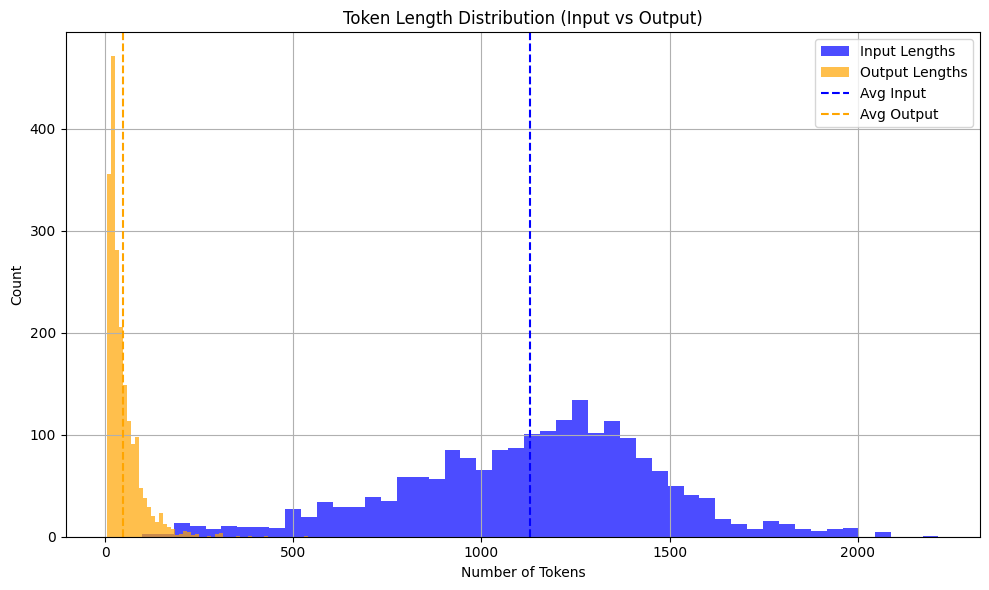

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")

# Sample 1000 rows from Huggingface Dataset
random.seed(42)
sampled_rows = random.sample(list(train_data_extract), 2000)

# Tokenize inputs and outputs
input_lengths = [len(tokenizer(row["input"]).input_ids) for row in sampled_rows]
output_lengths = [len(tokenizer(row["output"]).input_ids) for row in sampled_rows]

# Print averages
print(f"Average input length:  {np.mean(input_lengths):.2f} tokens")
print(f"Average output length: {np.mean(output_lengths):.2f} tokens")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(input_lengths, bins=50, alpha=0.7, label="Input Lengths", color='blue')
plt.hist(output_lengths, bins=50, alpha=0.7, label="Output Lengths", color='orange')
plt.axvline(np.mean(input_lengths), color='blue', linestyle='--', label="Avg Input")
plt.axvline(np.mean(output_lengths), color='orange', linestyle='--', label="Avg Output")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.title("Token Length Distribution (Input vs Output)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import random

random_int = random.randint(0, len(train_data_extract) - 1)
print(f"Randomly selected index: {random_int}")
print(f"Input: {train_data_extract[random_int]['input']}")
print(f"Output: {train_data_extract[random_int]['output']}")

Randomly selected index: 16155
Input: What question was asked by the user if this <t>Curious Kids: How did some animals evolve wings to fly? (theconversation.com)</t> <c>Perhaps the first thing you notice when you see a bird is its amazing ability to fly. Modern birds fly using their “arms”, which have feathers and very strong flight muscles.</c> <t>Curious Kids: How did some animals evolve wings to fly? (theconversation.com)</t> <c>Many species of birds can run up very steep slopes or even vertical surfaces. Young birds do it by furiously flapping their wings in order to push them against the incline. Otherwise they fall or slide off. This may have been another use for the stubby wings of some small, feathered dinosaurs. These wings then gradually became more powerful and covered in feathers and were eventually used to fly.</c> <t>Curious Kids: How did some animals evolve wings to fly? (theconversation.com)</t> <c>But the first animals to fly by flapping are very much older than birds

### Now try to train with extract as well

### This is without extract
* We use a model with a bigger context. To ensure apples-to-apples, we first run a "baseline" with that new model without extract, to understand if it's really the extract that improves.

In [ ]:
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    LongT5ForConditionalGeneration,
    AutoTokenizer,
)

# Load FLAN-T5 small model and tokenizer - now using with extract data
flan_no_extract_tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")
flan_no_extract_model = LongT5ForConditionalGeneration.from_pretrained("google/long-t5-tglobal-base")
flan_no_extract_model.config.use_cache = False
if hasattr(flan_no_extract_model, "generation_config"):
    flan_no_extract_model.generation_config.use_cache = False

# Use train_data (without extract) for tokenization and training
def tokenize_longt5_no_extract(row):
    return flan_no_extract_tokenizer(row["input"], text_target=row["output"], truncation=True, max_length=1500)

longt5_tokenized_data = train_data.map(tokenize_longt5_no_extract, remove_columns=["input", "output"])

# Split the data
longt5_train_ds, longt5_eval_ds = longt5_tokenized_data.train_test_split(test_size=0.2, seed=42).values()

# Training arguments (reuse or adjust as needed)
longt5_training_args = TrainingArguments(
    output_dir="long-t5-question-generator-no-extract",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=3e-4,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
    eval_strategy="epoch",
    gradient_accumulation_steps=2
)

# Data collator
longt5_data_collator = DataCollatorForSeq2Seq(flan_no_extract_tokenizer, model=flan_no_extract_model)

# Trainer
longt5_trainer = Trainer(
    model=flan_no_extract_model,
    args=longt5_training_args,
    train_dataset=longt5_train_ds,
    eval_dataset=longt5_eval_ds,
    tokenizer=flan_no_extract_tokenizer,
    data_collator=longt5_data_collator,
)

# Train
longt5_trainer.train()

# Evaluate
longt5_results = comprehensive_evaluation(longt5_eval_ds, flan_no_extract_model, flan_no_extract_tokenizer, num_examples=3000)
eval_df = pd.read_csv("results_including_flan_t5_small_only_title.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([longt5_results], index=["long_t5_tglobal_base_no_extract"])])
eval_df.to_csv("results_including_long_t5_tglobal_base_no_extract.csv")

Map: 100%|██████████| 37964/37964 [00:18<00:00, 1998.50 examples/s]
/tmp/ipykernel_984269/2724876185.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  longt5_trainer = Trainer(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.970800,2.516858
2,2.656700,2.414845
3,2.477300,2.380436


/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/

Evaluating on 3000 examples...


100%|██████████| 3000/3000 [12:19<00:00,  4.06it/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:02<00:00, 17.63it/s]


=== EVALUATION RESULTS ===
BERTScore F1: 0.3384 ↑ (higher = more semantically similar)
BERTScore Precision: 0.4778 ↑
BERTScore Recall: 0.2078 ↑
BLEU Score: 0.0055 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.2617 ↑
ROUGE-2 F1: 0.1109 ↑
ROUGE-L F1: 0.2371 ↑ (longest common subsequence)
Perplexity: 7.0716 ↓ (lower = more confident model)

=== SAMPLE PREDICTIONS ===

Example 1:
Input: What question was asked by the user if this t>How does colorblindness work? | Scienceline (scienceline.org) ; How Color Blindness Works (www.colour-blindness.com) ; What Is Color Blindness? (www.webmd.com)/t>
Expected output: How does color-blindness work?
Generated output: How does colorblindness work?

Example 2:
Input: What question was asked by the user if this t>A New Methodology for Calculating Launch Vehicle Ascent Loads (sbir.nasa.gov) ; 1985008580.pdf (ntrs.nasa.gov) ; Space Shuttle Orbiter Structures & Thermal Protection System (TPS) | Alan Tatourian (tatourian.blog)/t>
Expected output: What is 

### This is with extract:

In [4]:
from transformers import LongT5ForConditionalGeneration
from transformers import AutoTokenizer
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    LongT5ForConditionalGeneration,
    AutoTokenizer,
)

# Load FLAN-T5 small model and tokenizer - now using with extract data
flan_extract_tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-base")
flan_extract_model = LongT5ForConditionalGeneration.from_pretrained("google/long-t5-tglobal-base")
flan_extract_model.config.use_cache = False
if hasattr(flan_extract_model, "generation_config"):
    flan_extract_model.generation_config.use_cache = False

# Tokenize data for Long-T5 with extract
def tokenize_flan_extract(row):
    return flan_extract_tokenizer(row["input"], text_target=row["output"], truncation=True, max_length=1500)

flan_extract_tokenized_data = train_data_extract.map(tokenize_flan_extract, remove_columns=["input", "output"])

# Split the data
flan_extract_train_ds, flan_extract_eval_ds = flan_extract_tokenized_data.train_test_split(test_size=0.2, seed=42).values()

# Training arguments for Long-T5 with extract
flan_extract_training_args = TrainingArguments(
    output_dir="long-t5-question-generator-extract",
    per_device_train_batch_size=2,  # Smaller batch size for larger model
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=3e-4,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
    eval_strategy="epoch",
    gradient_accumulation_steps=2  # Compensate for smaller batch size
)

# Data collator
flan_extract_data_collator = DataCollatorForSeq2Seq(flan_extract_tokenizer, model=flan_extract_model)

# Create trainer
flan_extract_trainer = Trainer(
    model=flan_extract_model,
    args=flan_extract_training_args,
    train_dataset=flan_extract_train_ds,
    eval_dataset=flan_extract_eval_ds,
    tokenizer=flan_extract_tokenizer,
    data_collator=flan_extract_data_collator,
)

# Train the model
flan_extract_trainer.train()

# Run comprehensive evaluation
flan_extract_results = comprehensive_evaluation(flan_extract_eval_ds, flan_extract_model, flan_extract_tokenizer, num_examples=3000)
eval_df = pd.read_csv("results_including_long_t5_tglobal_base_no_extract.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([flan_extract_results], index=["long_t5_tglobal_base_with_extract"])])
eval_df.to_csv("results_including_long_t5_tglobal_base_with_extract.csv")

Map: 100%|██████████| 38161/38161 [01:56<00:00, 327.57 examples/s]
/tmp/ipykernel_4189864/3552005596.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  flan_extract_trainer = Trainer(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.739600,2.370589
2,2.369100,2.236821
3,2.143200,2.190469


/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/

NameError: name 'comprehensive_evaluation' is not defined

In [6]:

# Run comprehensive evaluation
flan_extract_results = comprehensive_evaluation(flan_extract_eval_ds, flan_extract_model, flan_extract_tokenizer, num_examples=3000)
eval_df = pd.read_csv("results_including_long_t5_tglobal_base_no_extract.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([flan_extract_results], index=["long_t5_tglobal_base_with_extract"])])
eval_df.to_csv("results_including_long_t5_tglobal_base_with_extract.csv")

Evaluating on 3000 examples...


100%|██████████| 3000/3000 [13:00<00:00,  3.85it/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


=== EVALUATION RESULTS ===
BERTScore F1: 0.3452 ↑ (higher = more semantically similar)
BERTScore Precision: 0.4772 ↑
BERTScore Recall: 0.2212 ↑
BLEU Score: 0.0072 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.2742 ↑
ROUGE-2 F1: 0.1215 ↑
ROUGE-L F1: 0.2463 ↑ (longest common subsequence)
Perplexity: 7.0619 ↓ (lower = more confident model)

=== SAMPLE PREDICTIONS ===

Example 1:
Input: What question was asked by the user if this t>Galvanic Cells (Voltaic Cell) - Definition, Working Principle & Examples with Videos (byjus.com)/t> c>An electrochemical cell that converts the chemical energy of spontaneous redox reactions into electrical energy is known as a galvanic cell or a voltaic cell. Galvanic cell Voltaic cell is an electrochemical cell that makes use of chemical reactions to generate electrical energy. Let us understand how a voltaic or galvanic cell is created. In oxidation-reduction reactions, electrons are moved from one species to another species. Energy is released if the react

In [ ]:
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

# Load GPT2 model and tokenizer for extract training
gpt2_extract_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_extract_tokenizer.pad_token = gpt2_extract_tokenizer.eos_token
gpt2_extract_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenize data for GPT2 with extract (causal language modeling)
def tokenize_gpt2_extract(row):
    text = row["input"] + " " + row["output"] + gpt2_extract_tokenizer.eos_token
    return gpt2_extract_tokenizer(text, truncation=True, max_length=1024)

gpt2_extract_tokenized_data = train_data_extract.map(tokenize_gpt2_extract, remove_columns=["input", "output"])

# Split the data
gpt2_extract_train_ds, gpt2_extract_eval_ds = gpt2_extract_tokenized_data.train_test_split(test_size=0.2, seed=42).values()

# Training arguments for GPT2 with extract
gpt2_extract_training_args = TrainingArguments(
    output_dir="gpt2-question-generator-extract",
    per_device_train_batch_size=2,  # Smaller batch size due to longer sequences
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
    eval_strategy="epoch",
    gradient_accumulation_steps=4  # Compensate for smaller batch size
)

# Data collator for language modeling
gpt2_extract_data_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt2_extract_tokenizer,
    mlm=False,  # Causal language modeling, not masked
)

# Create trainer
gpt2_extract_trainer = Trainer(
    model=gpt2_extract_model,
    args=gpt2_extract_training_args,
    train_dataset=gpt2_extract_train_ds,
    eval_dataset=gpt2_extract_eval_ds,
    tokenizer=gpt2_extract_tokenizer,
    data_collator=gpt2_extract_data_collator,
)

# Train the model
gpt2_extract_trainer.train()

# Run comprehensive evaluation on GPT2 with extract
results_gpt2_extract = evaluate_gpt2_on_raw(train_data_extract, gpt2_extract_model, gpt2_extract_tokenizer, num_examples=3000, max_new_tokens=512)
eval_df = pd.read_csv("results_including_long_t5_tglobal_base_with_extract.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([results_gpt2_extract], index=["gpt2_with_extract"])])
eval_df.to_csv("results_including_gpt2_with_extract.csv")
eval_df

Map: 100%|██████████| 38161/38161 [01:31<00:00, 418.45 examples/s]
/tmp/ipykernel_3411862/4201518520.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  gpt2_extract_trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.794800,1.508719
2,0.772000,1.493003
3,0.754300,1.487664


/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/devel/miniconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Generate:   0%|          | 2/3000 [00:07<3:02:04,  3.64s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may obse

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [14]:
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)

# load model from
gpt2_extract_tokenizer = GPT2TokenizerFast.from_pretrained("/home/devel/temp/school/nlp/project/gpt2-question-generator-extract/checkpoint-5724")
gpt2_extract_tokenizer.pad_token = gpt2_extract_tokenizer.eos_token
gpt2_extract_model = GPT2LMHeadModel.from_pretrained("/home/devel/temp/school/nlp/project/gpt2-question-generator-extract/checkpoint-5724")


# Run comprehensive evaluation on GPT2 with extract
results_gpt2_extract = evaluate_gpt2_on_raw(train_data_extract, gpt2_extract_model, gpt2_extract_tokenizer, num_examples=3000, max_new_tokens=512)
eval_df = pd.read_csv("results_including_long_t5_tglobal_base_with_extract.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([results_gpt2_extract], index=["gpt2_with_extract"])])
eval_df.to_csv("results_including_gpt2_with_extract.csv")
eval_df

Generate:   0%|          | 2/3000 [00:29<12:14:01, 14.69s/it]


IndexError: index out of range in self

In [ ]:
def evaluate_gpt2_on_raw_robust(raw_dataset, model, tokenizer, num_examples=1000, max_new_tokens=128, max_length=1024):
    """
    More robust version of evaluate_gpt2_on_raw that handles problematic inputs
    """
    model.eval()
    n = len(raw_dataset) if (num_examples is None) else min(num_examples, len(raw_dataset))
    subset = raw_dataset.select(range(n))

    preds, refs = [], []
    skipped_count = 0

    # 1) Generate predictions from INPUT only
    for i, ex in enumerate(tqdm(subset, desc="Generate")):
        try:
            input_text = ex["input"]
            ref_text = ex["output"]
            
            # Skip if input is too long
            if len(input_text) > max_length * 4:  # rough character limit
                skipped_count += 1
                continue
                
            # Tokenize with truncation
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length)
            
            # Check for out-of-bounds tokens
            if inputs.input_ids.max().item() >= model.config.vocab_size:
                print(f"Skipping sample {i}: out-of-bounds token detected")
                skipped_count += 1
                continue
                
            inputs = inputs.to(model.device)
            
            with torch.no_grad():
                out_ids = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                )
            pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)
            preds.append(pred)
            refs.append(ref_text)
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            skipped_count += 1
            continue

    print(f"Processed {len(preds)} samples, skipped {skipped_count}")
    
    if len(preds) == 0:
        print("No valid predictions generated!")
        return None

    # 2) Semantic & surface metrics
    bertscore = evaluate.load("bertscore").compute(predictions=preds, references=refs, lang="en")
    rouge     = evaluate.load("rouge").compute(predictions=preds, references=refs)
    bleu      = evaluate.load("bleu").compute(predictions=preds, references=[[r] for r in refs])

    b_f1 = float(np.mean(bertscore["f1"]))
    b_p  = float(np.mean(bertscore["precision"]))
    b_r  = float(np.mean(bertscore["recall"]))

    # 3) Perplexity on OUTPUT ONLY (mask prompt tokens) - use smaller subset for speed
    losses = []
    ppl_subset = subset.select(range(min(50, len(preds))))  # Use first 50 successful samples
    
    for i, ex in enumerate(tqdm(ppl_subset, desc="PPL")):
        try:
            prompt_ids = tokenizer(ex["input"], add_special_tokens=False, truncation=True, max_length=max_length//2)["input_ids"]
            target_ids = tokenizer(ex["output"], add_special_tokens=False, truncation=True, max_length=max_length//2)["input_ids"]
            
            full_ids = prompt_ids + target_ids + [tokenizer.eos_token_id]
            if len(full_ids) > max_length:
                continue  # Skip if too long
                
            ids = torch.tensor(full_ids).unsqueeze(0).to(model.device)
            labels = ids.clone()
            labels[:, :len(prompt_ids)] = -100  # ignore prompt
            
            with torch.no_grad():
                loss = model(input_ids=ids, labels=labels).loss.item()
            losses.append(loss)
        except Exception as e:
            print(f"Error calculating perplexity for sample {i}: {e}")
            continue

    if losses:
        ppl = float(math.exp(np.mean(losses)))
    else:
        ppl = float('inf')  # If no perplexity could be calculated

    print("\n=== EVALUATION RESULTS ===")
    print(f"BERTScore F1: {b_f1:.4f} ↑ (higher = more semantically similar)")
    print(f"BERTScore Precision: {b_p:.4f} ↑")
    print(f"BERTScore Recall: {b_r:.4f} ↑")
    print(f"BLEU Score: {bleu['bleu']:.4f} ↑ (higher = more phrase overlap)")
    print(f"ROUGE-1 F1: {rouge['rouge1']:.4f} ↑")
    print(f"ROUGE-2 F1: {rouge['rouge2']:.4f} ↑")
    print(f"ROUGE-L F1: {rouge['rougeL']:.4f} ↑ (longest common subsequence)")
    print(f"Perplexity (output-only): {ppl:.4f} ↓ (lower = more confident model)")

    return {
        "bertscore_f1": b_f1,
        "bertscore_precision": b_p,
        "bertscore_recall": b_r,
        "bleu": bleu["bleu"],
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "perplexity": ppl,
        "samples_processed": len(preds),
        "samples_skipped": skipped_count
    }

In [ ]:
# Test the robust evaluation function
print("Testing robust evaluation function...")
results_gpt2_extract_robust = evaluate_gpt2_on_raw_robust(
    train_data_extract, 
    gpt2_extract_model, 
    gpt2_extract_tokenizer, 
    num_examples=100,  # Start with smaller number
    max_new_tokens=128,
    max_length=512  # Smaller max length to avoid issues
)

eval_df = pd.read_csv("results_including_long_t5_tglobal_base_with_extract.csv", index_col=0)
eval_df = pd.concat([eval_df, pd.DataFrame([results_gpt2_extract_robust], index=["gpt2_with_extract"])])
eval_df.to_csv("results_including_gpt2_with_extract.csv")
eval_df

Testing robust evaluation function...


Generate: 100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Processed 51 samples, skipped 49


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PPL: 100%|██████████| 50/50 [00:04<00:00, 11.69it/s]


=== EVALUATION RESULTS ===
BERTScore F1: 0.7872 ↑ (higher = more semantically similar)
BERTScore Precision: 0.7380 ↑
BERTScore Recall: 0.8438 ↑
BLEU Score: 0.0052 ↑ (higher = more phrase overlap)
ROUGE-1 F1: 0.0517 ↑
ROUGE-2 F1: 0.0192 ↑
ROUGE-L F1: 0.0464 ↑ (longest common subsequence)
Perplexity (output-only): 130.0749 ↓ (lower = more confident model)


### Report

,bleu,rouge1,rouge2,rougeL,bertscore_f1,bertscore_precision,bertscore_recall,perplexity,samples_processed,samples_skipped
Model,,,,,,,,,,
t5_small_only_title,0.004914,0.247088,0.098434,0.223263,0.315411,0.450722,0.188689,15.403170,NaN,NaN
t5_small_baseline,0.009406,0.160242,0.042990,0.130303,-0.058683,-0.181792,0.070558,75.238684,NaN,NaN
gpt2_only_title,0.003058,0.046986,0.009768,0.034573,0.772086,0.718331,0.835581,23.359847,NaN,NaN
flan_t5_small_only_title,0.010333,0.247322,0.098531,0.223712,0.309271,0.440461,0.187329,10.307720,NaN,NaN
long_t5_tglobal_base_no_extract,0.005510,0.261654,0.110871,0.237065,0.338375,0.477757,0.207826,7.071643,NaN,NaN
long_t5_tglobal_base_with_extract,0.007220,0.274203,0.121548,0.246307,0.345160,0.477222,0.221210,7.061938,NaN,NaN
gpt2_with_extract,0.005217,0.051701,0.019227,0.046433,0.787217,0.737987,0.843794,130.074900,51.0,49.0


/tmp/ipykernel_3959220/1172212363.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


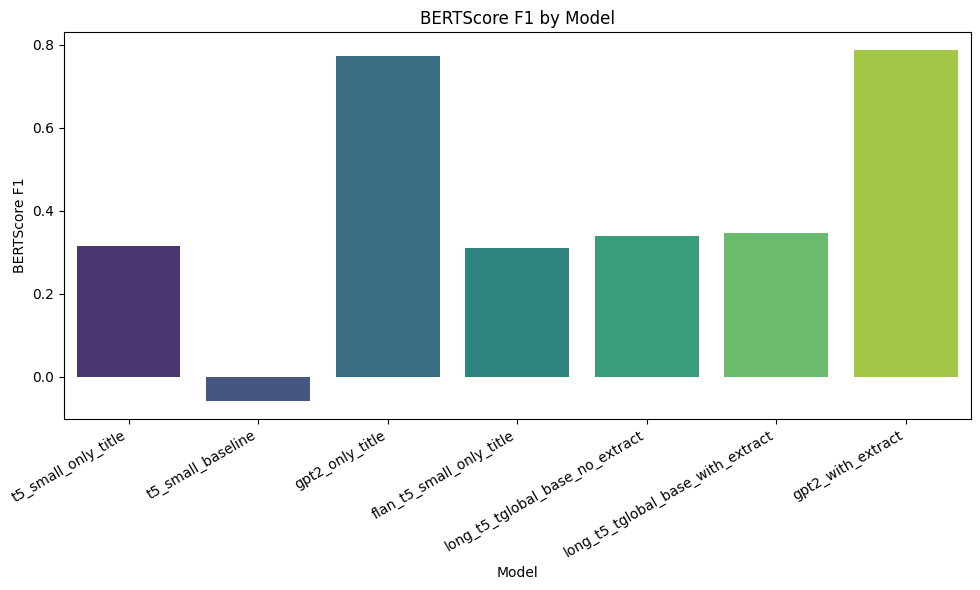

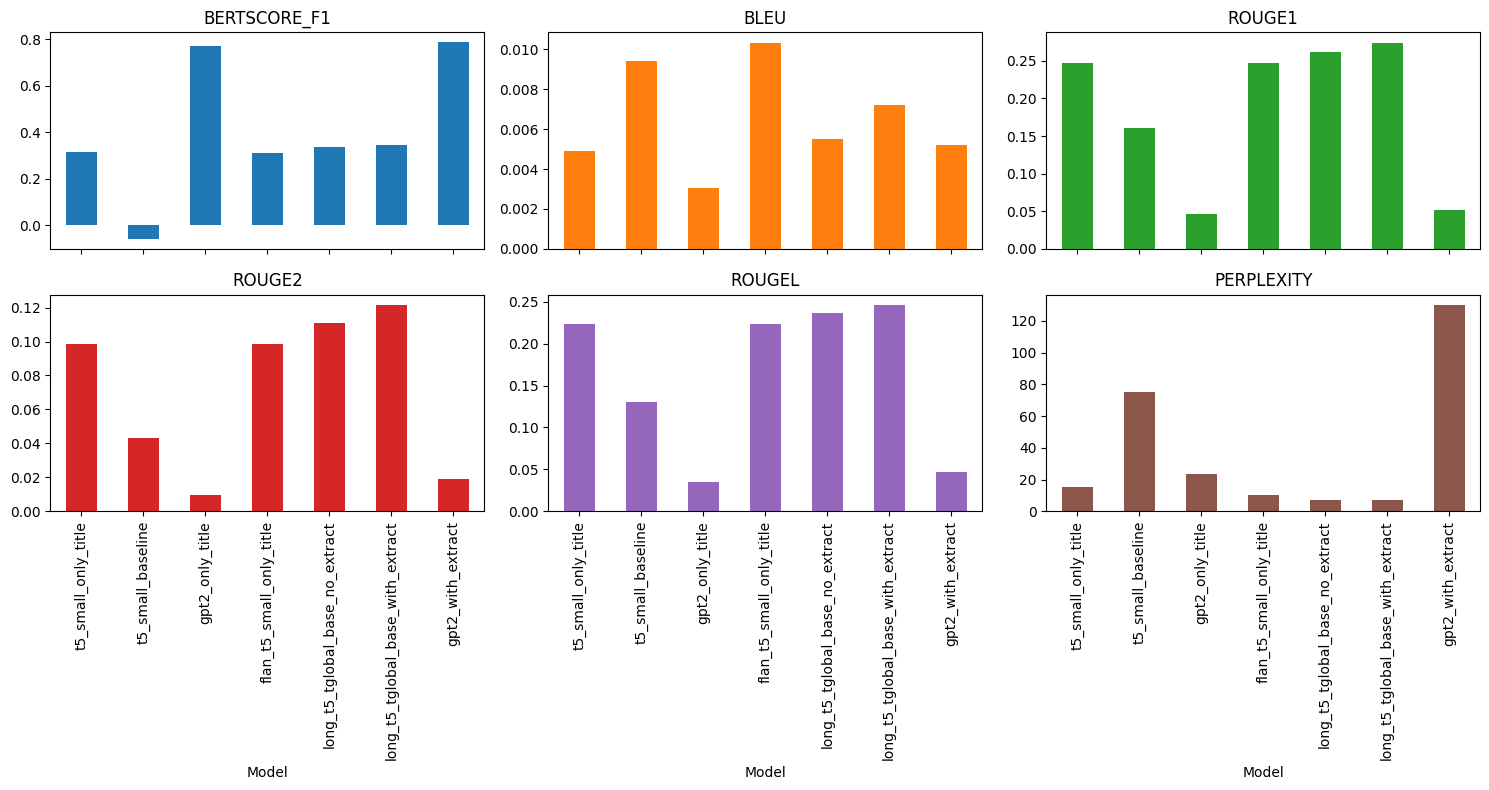

Best model by BERTScore F1: gpt2_with_extract (0.7872)


,bleu,rouge1,rouge2,rougeL,bertscore_f1,bertscore_precision,bertscore_recall,perplexity,samples_processed,samples_skipped
Model,,,,,,,,,,
gpt2_with_extract,0.005217,0.051701,0.019227,0.046433,0.787217,0.737987,0.843794,130.074900,51.0,49.0
gpt2_only_title,0.003058,0.046986,0.009768,0.034573,0.772086,0.718331,0.835581,23.359847,NaN,NaN
long_t5_tglobal_base_with_extract,0.007220,0.274203,0.121548,0.246307,0.345160,0.477222,0.221210,7.061938,NaN,NaN
long_t5_tglobal_base_no_extract,0.005510,0.261654,0.110871,0.237065,0.338375,0.477757,0.207826,7.071643,NaN,NaN
t5_small_only_title,0.004914,0.247088,0.098434,0.223263,0.315411,0.450722,0.188689,15.403170,NaN,NaN
flan_t5_small_only_title,0.010333,0.247322,0.098531,0.223712,0.309271,0.440461,0.187329,10.307720,NaN,NaN
t5_small_baseline,0.009406,0.160242,0.042990,0.130303,-0.058683,-0.181792,0.070558,75.238684,NaN,NaN


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


# Ensure eval_df index is model names
eval_df_plot = eval_df.copy()
eval_df_plot.index.name = "Model"

# Display the dataframe
display(eval_df_plot)

# Plot BERTScore F1 for all models
plt.figure(figsize=(10, 6))
sns.barplot(
    x=eval_df_plot.index,
    y="bertscore_f1",
    data=eval_df_plot,
    palette="viridis"
)
plt.title("BERTScore F1 by Model")
plt.ylabel("BERTScore F1")
plt.xlabel("Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Plot all metrics for each model
metrics = ["bertscore_f1", "bleu", "rouge1", "rouge2", "rougeL", "perplexity"]
eval_df_plot[metrics].plot(
    kind="bar",
    subplots=True,
    layout=(2, 3),
    figsize=(15, 8),
    legend=False,
    sharex=True,
    title=[m.upper() for m in metrics]
)
plt.tight_layout()
plt.show()

# Highlight the best model by BERTScore F1
best_model = eval_df_plot["bertscore_f1"].idxmax()
best_score = eval_df_plot.loc[best_model, "bertscore_f1"]
print(f"Best model by BERTScore F1: {best_model} ({best_score:.4f})")

# Print summary table sorted by BERTScore F1
display(eval_df_plot.sort_values("bertscore_f1", ascending=False))